In [2]:
%reload_ext dotenv
%dotenv
%reload_ext autoreload
%autoreload 2

In [16]:
import replicate
import requests
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
humans = {
    "model": {"name": "model", "image_path": "../images/humans/model.jpg"},
    "nimo": {"name": "nimo", "image_path": "../images/humans/nimo_underwear.jpg"},
}
garments = {
    "tshirt": {
        "name": "tshirt",
        "description": "purple t-shirt",
        "category": "upper_body",
        "image_path": "../images/garments/tops/tshirt.webp",
    },
    "sweater": {
        "name": "sweater",
        "description": "oversized pink sweater",
        "category": "upper_body",
        "image_path": "../images/garments/tops/sweater.jpg",
    },
    "striped_sweater": {
        "name": "striped_sweater",
        "description": "black and white striped sweater",
        "category": "upper_body",
        "image_path": "../images/garments/tops/striped_sweater.webp",
    },
    "winter_coat": {
        "name": "winter_coat",
        "description": "winter coat with fur lined hood",
        "category": "upper_body",
        "image_path": "../images/garments/tops/winter_coat.webp",
    },
    "raincoat": {
        "name": "raincoat",
        "description": "light blue hip-length raincoat",
        "category": "upper_body",
        "image_path": "../images/garments/tops/raincoat.webp",
    },
    "jeans": {
        "name": "jeans",
        "description": "slim fit washed jeans",
        "category": "lower_body",
        "image_path": "../images/garments/bottoms/jeans.webp",
    },
    "joggers": {
        "name": "joggers",
        "description": "pink joggers",
        "category": "lower_body",
        "image_path": "../images/garments/bottoms/joggers.jpg",
    },
    "gym_shorts": {
        "name": "gym_shorts",
        "description": "short white gym shorts",
        "category": "lower_body",
        "image_path": "../images/garments/bottoms/gym_shorts.webp",
    }
}

### Figure out where to draw the garment (pre-masking)

Only need to do this once per category/human combination. We need to save this mask because the Replicate API doesn't return the mask when putting the garment on the human.

In [ ]:
def generate_mask(category, human):
    input = {
        # Garment doesn't matter if mask_only is True
        "garm_img": open(next(iter(garments.values()))["image_path"], "rb"),
        "human_img": open(human["image_path"], "rb"),
        "category": category,
        "mask_only": True,
    }

    result_url = replicate.run(
        "cuuupid/idm-vton:c871bb9b046607b680449ecbae55fd8c6d945e0a1948644bf2361b3d021d3ff4",
        input=input,
    )
    
    return Image.open(requests.get(result_url, stream=True).raw)

In [ ]:
im = generate_mask(category="lower_body", human=humans["nimo"])
im.save(f"../images/masks/{humans["nimo"]["name"]}/pre/bottom.jpg")
im

### Put single garment on human

Needs a pre-mask for the given category/human combination

In [12]:
def put_garment(garment, human):
    input = {
        "garm_img": open(garment["image_path"], "rb"),
        "human_img": open(human["image_path"], "rb"),
        "mask_img": open(
            f"../images/masks/{human["name"]}/pre/top.jpg"
            if garment["category"] == "upper_body"
            else f"../images/masks/{human["name"]}/pre/bottom.jpg",
            "rb",
        ),
        "garment_des": garment["description"],
        "category": garment["category"],
    }

    result_url = replicate.run(
        "cuuupid/idm-vton:c871bb9b046607b680449ecbae55fd8c6d945e0a1948644bf2361b3d021d3ff4",
        input=input,
    )

    return Image.open(requests.get(result_url, stream=True).raw)

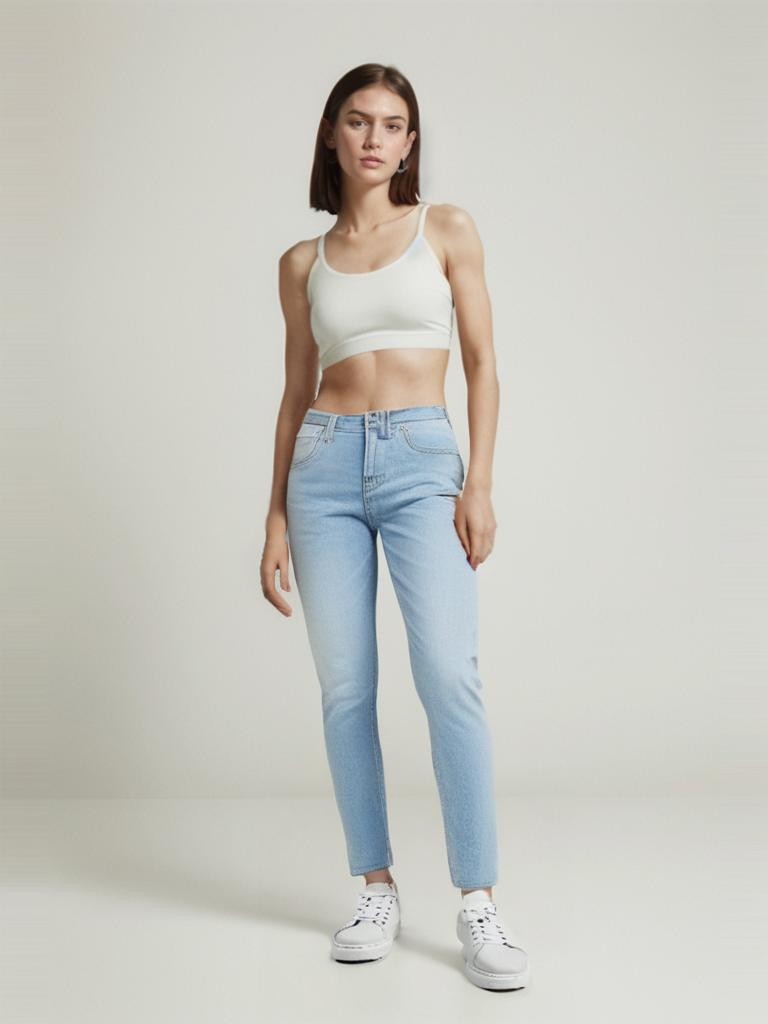

In [13]:
garment = garments["jeans"]
human = humans["model"]

im = put_garment(garment, human)
im.save(f"../images/results/{human["name"]}/single/{garment["name"]}.jpg")
im

In [ ]:
human = humans["nimo"]
for garment in tqdm(garments.values()):
    im = put_garment(garment, human)
    im.save(f"../images/results/{human["name"]}/single/{garment["name"]}.jpg")

### Find out where the top garment was drawn (post-masking)

Needs to be done for every top garment/human combination

Input tokens: 301
Thinking tokens: None
Output tokens: 301
[Object(box_2d=[395, 372, 869, 650], mask=''), Object(box_2d=[856, 430, 939, 526], mask=''), Object(box_2d=[736, 890, 932, 1000], mask=''), Object(box_2d=[198, 398, 363, 592], mask=''), Object(box_2d=[60, 338, 969, 690], mask='')]

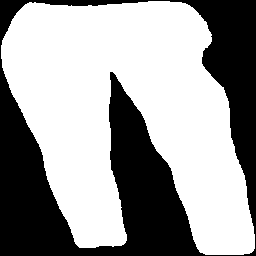
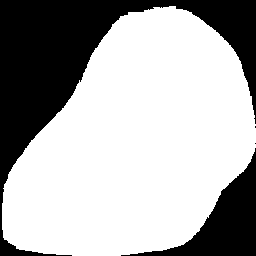
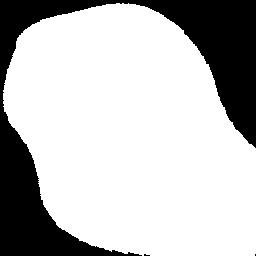
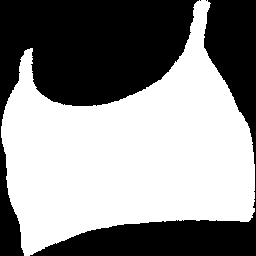
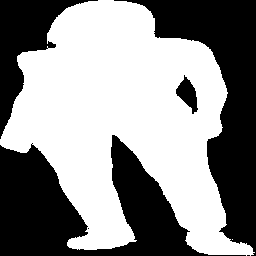

In [2]:
from google import genai
from google.genai.types import GenerateContentConfig, ThinkingConfig
from pydantic import BaseModel, TypeAdapter
import re

client = genai.Client()

woa_image = Image.open("../images/results/model/single/jeans.jpg")


class Object(BaseModel):
    box_2d: list[int]
    mask: str


ObjectList = TypeAdapter(list[Object])

response = client.models.generate_content(
    model="gemini-2.5-flash-preview-04-17",
    contents=[
        woa_image,
        """
        Give the segmentation masks for the objects. 
        Output a JSON list of segmentation masks where each entry contains the 2D bounding box in "box_2d" and the mask in "mask".
        """.strip(),
    ],
    config=GenerateContentConfig(
        thinking_config=ThinkingConfig(thinking_budget=0),
    ),
)
assert response.text is not None
assert response.usage_metadata is not None
print("Input tokens:", response.usage_metadata.prompt_token_count)
print("Thinking tokens:", response.usage_metadata.thoughts_token_count)
print("Output tokens:", response.usage_metadata.candidates_token_count)

text = response.text.strip()
text = re.sub(r"^```json", "", text)
text = re.sub(r"```$", "", text)
parsed = ObjectList.validate_json(text)
print(parsed)

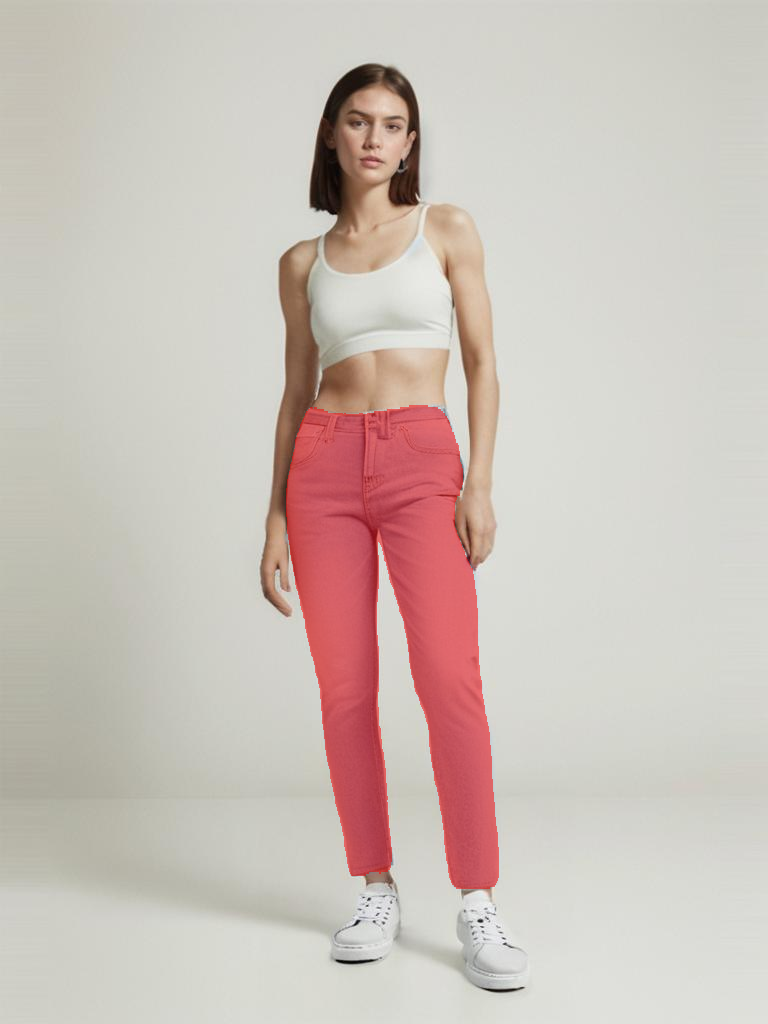

In [10]:
import base64
from io import BytesIO
from PIL.Image import Resampling
import numpy as np

# Assume parsed is a list of Object(s), handle the first mask for demonstration
mask_b64 = re.sub(r"^data:image/png;base64,", "", parsed[0].mask)

# Decode base64 PNG mask
mask_bytes = base64.b64decode(mask_b64)
mask_img = Image.open(BytesIO(mask_bytes)).convert("L")  # Grayscale mask

# Our data is [ymin, xmin, ymax, xmax] in 0-1000
ymin, xmin, ymax, xmax = parsed[0].box_2d
w, h = woa_image.size

# Normalize if any value > 1000 (as in JS)
if any(v > 1000 for v in (ymin, xmin, ymax, xmax)):
    ymin = (ymin / h) * 1000
    xmin = (xmin / w) * 1000
    ymax = (ymax / h) * 1000
    xmax = (xmax / w) * 1000

# Convert to normalized [0,1] coordinates
nYmin, nXmin, nYmax, nXmax = [v / 1000 for v in (ymin, xmin, ymax, xmax)]

# Compute pixel coordinates
left   = int(round(nXmin * w))
top    = int(round(nYmin * h))
right  = int(round(nXmax * w))
bottom = int(round(nYmax * h))

box_width = max(1, right - left)
box_height = max(1, bottom - top)

# Resize the mask to fit the bounding box
mask_box_resized = mask_img.resize((box_width, box_height), resample=Resampling.BILINEAR)

# Paste the resized mask into a full-size mask at the correct position
mask_resized = Image.new("L", woa_image.size, 0)
mask_resized.paste(mask_box_resized, (left, top))

# Create an RGBA version of woa_image
woa_rgba = woa_image.convert("RGBA")

# Create a color overlay (e.g., red) with 50% opacity where mask is present
overlay = Image.new("RGBA", woa_image.size, (255, 0, 0, 0))
mask_np = np.array(mask_resized)
alpha = (mask_np > 0) * 128  # 50% opacity where mask is present
overlay_np = np.array(overlay)
overlay_np[..., 3] = alpha
overlay = Image.fromarray(overlay_np, mode="RGBA")

# Composite overlay onto woa_image
result = Image.alpha_composite(woa_rgba, overlay)

result


In [6]:
def mask_garment(garment, human):
    prompt = garment["name"].replace("_", " ")
    print(f"prompt: {repr(prompt)}")

    # negative_prompt = "underwear, shoes"
    # if garment["category"] == "upper_body":
    #     negative_prompt = "pants, " + negative_prompt
    # else:
    #     negative_prompt = "shirt, sweater, " + negative_prompt
    # print(f"negative_prompt: {repr(negative_prompt)}")


    input = {
        "image": open(garment["image_path"], "rb"),
        # "image": "https://replicate.delivery/yhqm/5bXKYlGeHNxwAiXqohpteZWyJ6NBLUpA9iOUOexfniMbnzqQB/output.jpg",
        "mask_prompt": prompt,
        "negative_mask_prompt": "",
        "adjustment_factor": 0
    }

    results = replicate.run(
        "schananas/grounded_sam:ee871c19efb1941f55f66a3d7d960428c8a5afcb77449547fe8e5a3ab9ebc21c",
        input=input
    )
    for result in results:
        print(f"result: {repr(result)}")
        # Results contains some other stuff, we only want the regular mask
        if result.endswith("/mask.jpg"):
            return Image.open(requests.get(result, stream=True).raw)
    raise ValueError("Could not get mask URL")

prompt: 'tshirt'
result: 'https://replicate.delivery/xezq/B2tWL7sHLXL6Mlhs2Rc1C2l3NWDsJoPOZPbMRHzbx4mkhvLF/annotated_picture_mask.jpg'
result: 'https://replicate.delivery/xezq/t63GSpGXf0TceEPQefoyyu9VBK0Z7fG1spjqyR0I586Qyw3lC/neg_annotated_picture_mask.jpg'
result: 'https://replicate.delivery/xezq/Q1qJsKdldbrIKJaDihwBg559ilV63SqBs1SNwLUeD1LJDfuUA/mask.jpg'


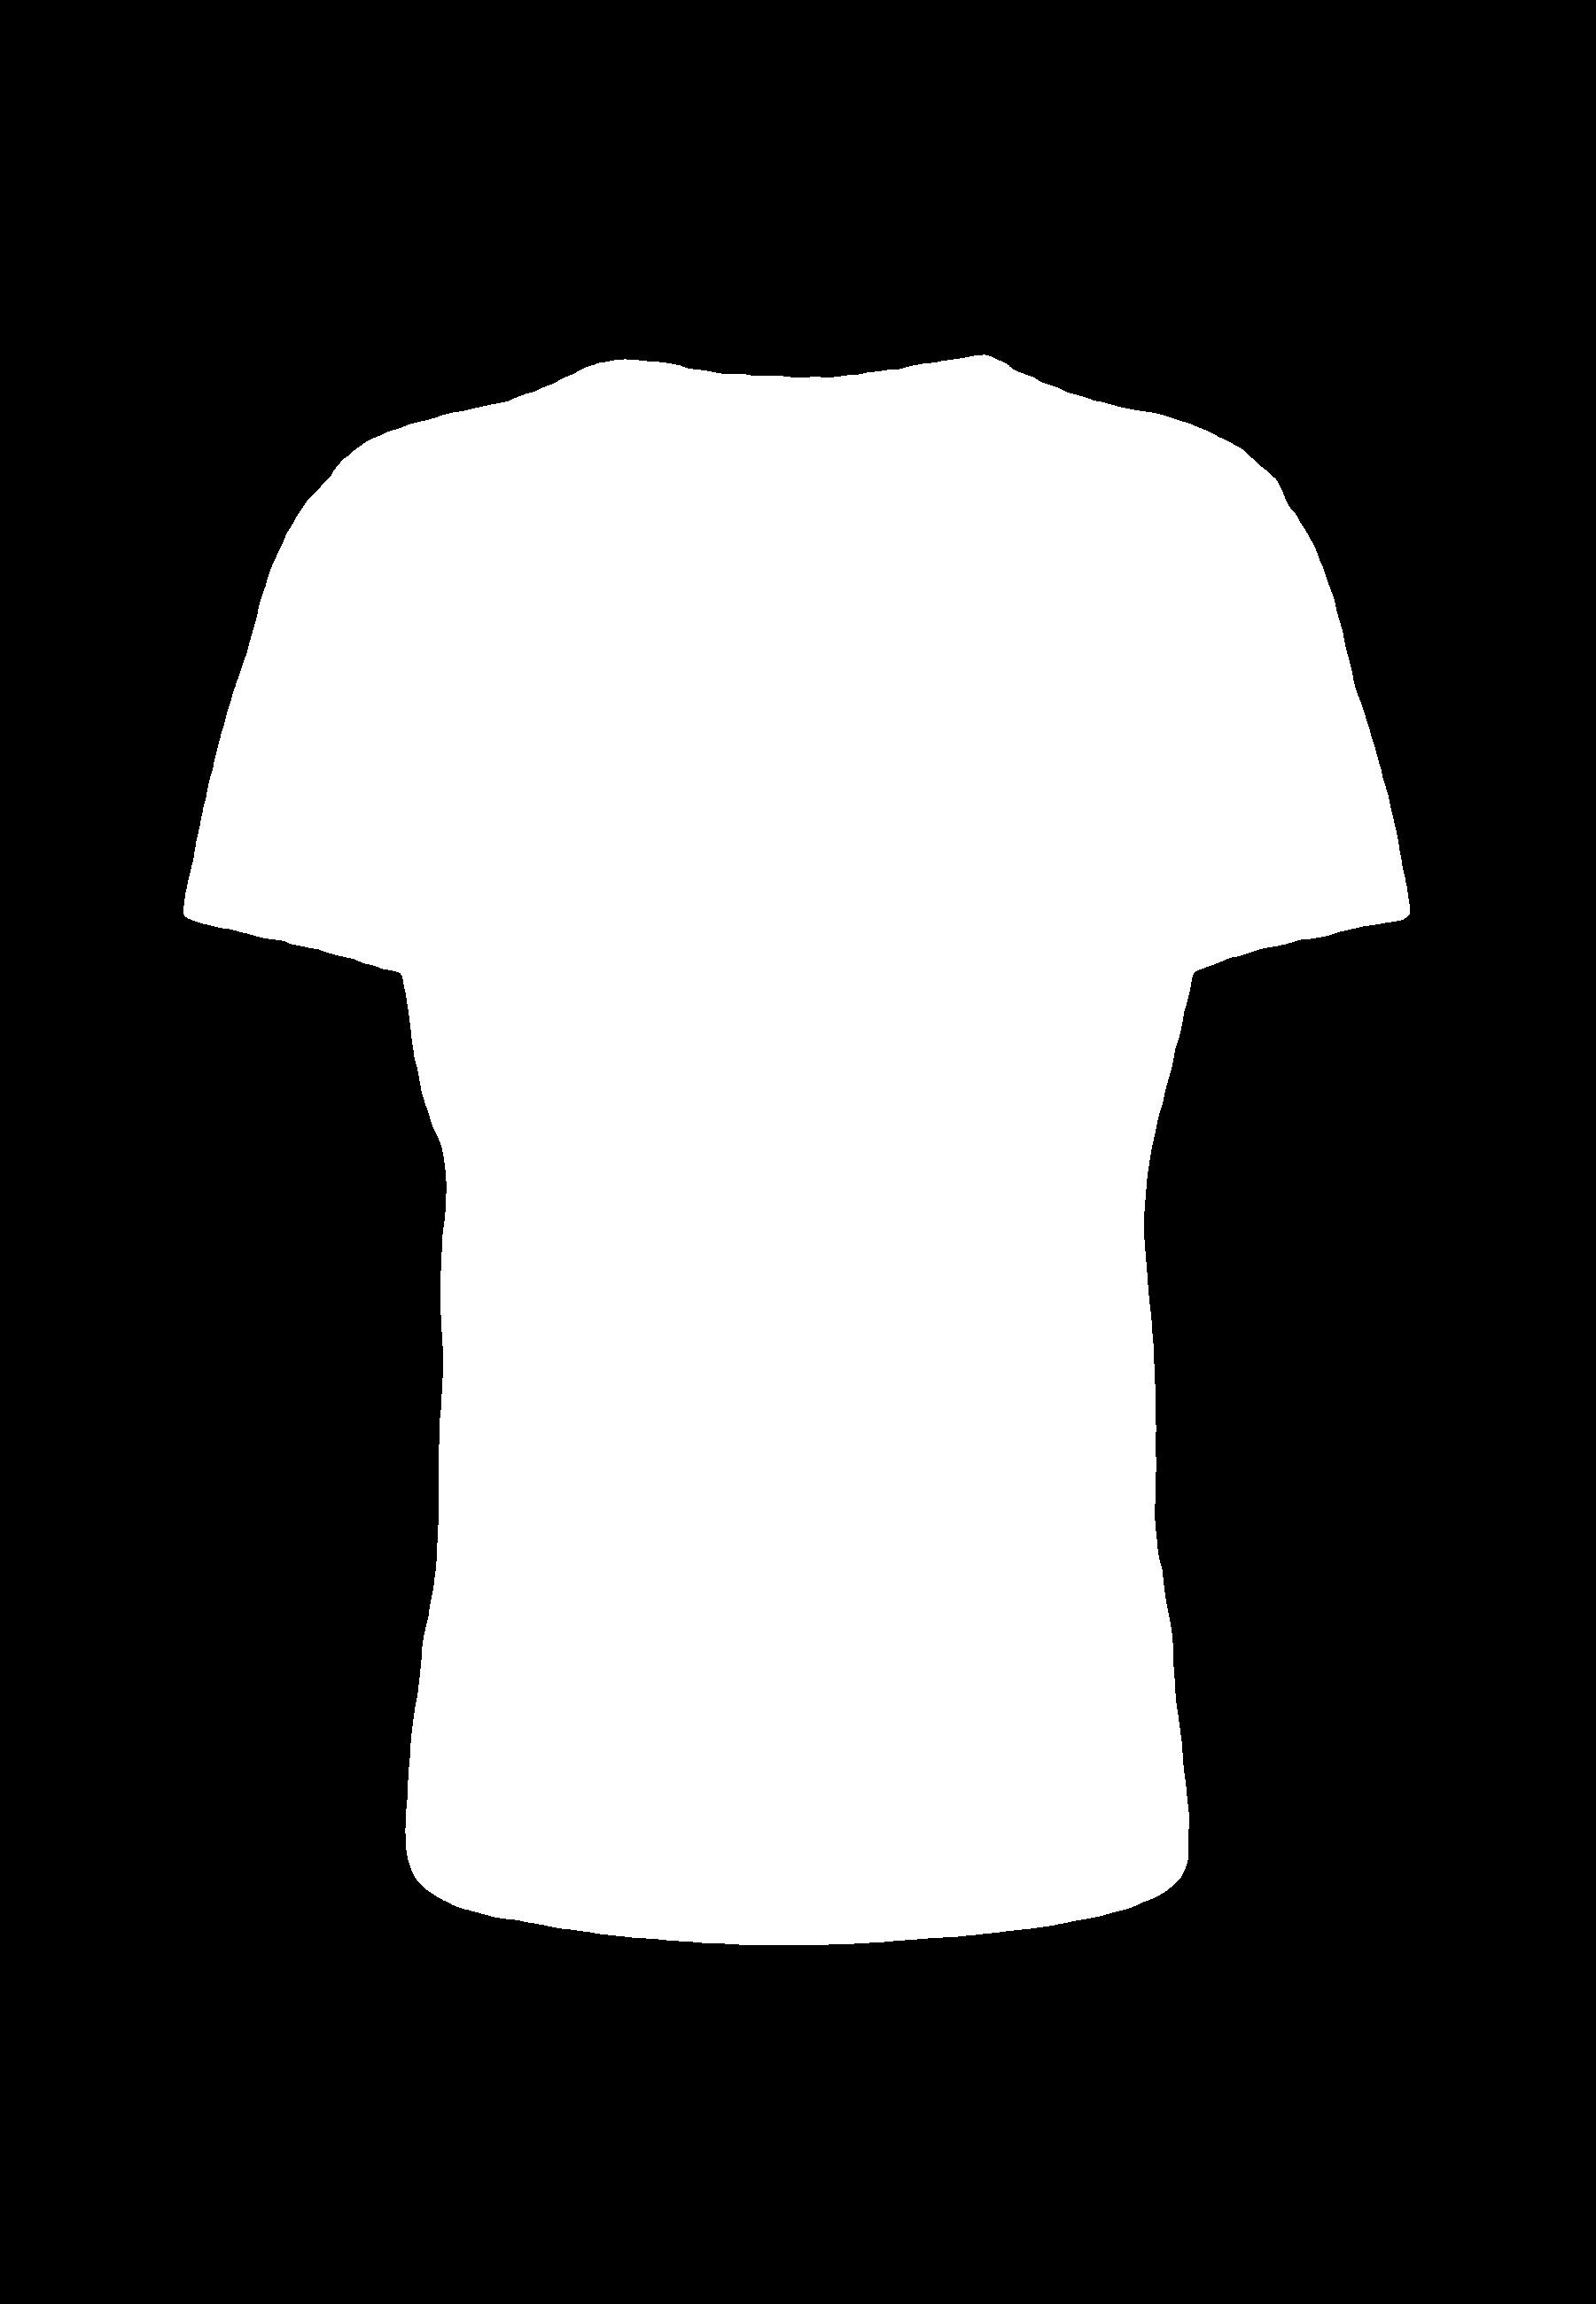

In [7]:
garment = garments["tshirt"]
human = humans["model"]

im = mask_garment(garment, human)
# im.save(f"../images/masks/{human["name"]}/post/{garment["name"]}.jpg")
im

In [ ]:
human = humans["nimo"]
for garment in tqdm(garments.values()):
    im = mask_garment(garment, human)
    im.save(f"../images/masks/{human["name"]}/post/{garment["name"]}.jpg")

### Combine garments

In [ ]:
from combining import combine_garments

human = humans["nimo"]
garment_top = garments["striped_sweater"]
garment_bottom = garments["jeans"]

human_im = Image.open(human["image_path"])
print(human_im.format, human_im.size, human_im.mode)

result_top_im = Image.open(
    f'../images/results/{human["name"]}/single/{garment_top["name"]}.jpg'
)
print(result_top_im.format, result_top_im.size, result_top_im.mode)

result_bottom_im = Image.open(
    f'../images/results/{human["name"]}/single/{garment_bottom["name"]}.jpg'
)
print(result_bottom_im.format, result_bottom_im.size, result_bottom_im.mode)

mask_top_im = Image.open(
    f'../images/masks/{human["name"]}/post/{garment_top["name"]}.jpg'
).convert("L")
print(mask_top_im.format, mask_top_im.size, mask_top_im.mode)

im = combine_garments(human_im, result_top_im, result_bottom_im, mask_top_im)
im.save(f"../images/results/{human["name"]}/multi/{garment_top["name"]}_{garment_bottom["name"]}.jpg")
im

In [ ]:
from dressme.db import engine
from sqlmodel import Session, select

from dressme.models import User

with Session(engine) as session:
    user = session.exec(select(User)).first()
    print(user)

### Playground

In [ ]:
import requests
from sqlmodel import Session, select
from dressme.db import engine
from dressme.db.models import AvatarImage, WearableOnAvatarImage, WearableImage

response = requests.get("https://replicate.delivery/yhqm/0taNqL73GoKhA13ZJFYIw6cZf0wEzWmtef4jUSfbQafj7XQhC/output.jpg")

with Session(engine) as session:
    avatar_image = session.exec(select(AvatarImage)).first()

    wearable_image = session.exec(select(WearableImage)).first()

    wearable_on_avatar_image = WearableOnAvatarImage(
        avatar_image=avatar_image,
        wearable_image=wearable_image,
        image_data=response.content,
        mask_image_data=b"",
    )
    session.add(wearable_on_avatar_image)

    print("ℹ️ THE ID:" + wearable_on_avatar_image.id.hex)

    session.commit()

In [ ]:
import io
from sqlmodel import Session, select
from dressme.db import engine
from dressme.db.models import AvatarImage, Wearable

with Session(engine) as session:
    avatar_image = session.exec(select(AvatarImage)).first()
    wearable = session.exec(select(Wearable)).first()

    wearable.wearable_image.image_data

    input = {
        "garm_img": io.BytesIO(wearable.wearable_image.image_data),
        "human_img": io.BytesIO(avatar_image.image_data),
        # "mask_img": open(
        #     avatar_mask_top_path
        #     if wearable.category == "upper_body"
        #     else avatar_mask_bottom_path,
        #     "rb",
        # ),
        "garment_des": wearable.description or "",
        "category": wearable.category,
    }

    result_url = replicate.run(
        "cuuupid/idm-vton:c871bb9b046607b680449ecbae55fd8c6d945e0a1948644bf2361b3d021d3ff4",
        input=input,
    )

    print(result_url)

In [ ]:
import io

import replicate
import requests
from sqlmodel import Session, select
from dressme.db import engine
from dressme.db.models import AvatarImage, Wearable

image_path = "../images/garments/tops/tshirt.webp"
category = "upper_body"
description = "purple t-shirt"

with Session(engine) as session:
    # TODO: use current user
    avatar_image = session.exec(select(AvatarImage)).first()

    wearable_image = WearableImage(image_data=open(image_path, "rb").read())
    session.add(wearable_image)

    wearable = Wearable(
        category=category,
        description=description,
        wearable_image=wearable_image,
    )
    session.add(wearable)

    input = {
        "garm_img": io.BytesIO(wearable_image.image_data),
        "human_img": io.BytesIO(avatar_image.image_data),
        # TODO: save avatar mask, then use it here
        # "mask_img": open(
        #     avatar_mask_top_path
        #     if category == "upper_body"
        #     else avatar_mask_bottom_path,
        #     "rb",
        # ),
        "garment_des": description or "",
        "category": category,
    }

    woa_image_url = replicate.run(
        "cuuupid/idm-vton:c871bb9b046607b680449ecbae55fd8c6d945e0a1948644bf2361b3d021d3ff4",
        input=input,
    )

    woa_image_response = requests.get(woa_image_url, stream=True)
    woa_image_response.raise_for_status()

    woa = WearableOnAvatarImage(
        avatar_image=avatar_image,
        wearable_image=wearable_image,
        image_data=woa_image_response.content,
        mask_image_data=b"", # TODO: do post masking
    )
    session.add(woa)

    session.commit()